In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("whitegrid")
pd.options.display.max_rows = 2000
pd.options.display.max_columns = 2000

In [8]:
columns=["unit","cycle","op_setting1","op_setting2","op_setting3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21" ,"sensor22","sensor23"]

X_train = pd.read_csv("/content/train_FD001.txt",sep=" ",names=columns, header=None)
X_test = pd.read_csv("/content/test_FD001.txt",sep=" ",names=columns, header=None)
rul_test = pd.read_csv("/content/RUL_FD001.txt",sep=" ",names=['remaining_usable_life', 'unwanted'], header=None)


In [10]:
X_train.head()

,unit,cycle,op_setting1,op_setting2,op_setting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [11]:
# drop all-null columns
X_train.drop(["sensor22","sensor23"], axis=1, inplace=True)
X_test.drop(["sensor22","sensor23"], axis=1, inplace=True)

# rul_test is ordered by unit, we can infer unit from that
rul_test.drop(["unwanted"], axis=1, errors='ignore', inplace=True)
rul_test['unit'] = rul_test.index+1

# let's set the "remaining cycles" as our dependent variable - this can be calculated
X_train_failed_cycle = X_train.groupby('unit')['cycle'].max().reset_index()
X_train_failed_cycle.columns = ['unit', 'failed_cycle']
X_train_merged = X_train.merge(X_train_failed_cycle, left_on='unit', right_on='unit', how='left')
y_train = (X_train_merged['failed_cycle'] - X_train_merged['cycle']).to_frame()
y_train.columns = ['remaining_cycles']

In [12]:
# let's derive remaining_cycles for the test set so we can treat that as our dependent variable
X_test_cycles_so_far = X_test.groupby('unit')['cycle'].max().to_frame().reset_index()
X_test_cycles_so_far.columns = ['unit', 'cycles_so_far']

rul_test['failed_cycle'] = rul_test['remaining_usable_life'] + X_test_cycles_so_far['cycles_so_far']
X_test_merged = X_test.merge(rul_test, left_on='unit', right_on='unit', how='left')

y_test = (X_test_merged['failed_cycle'] - X_test_merged['cycle']).to_frame()
y_train.columns = ['remaining_cycles']

In [13]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(20631, 26)
(20631, 1)
(13096, 26)
(13096, 1)


<Axes: >

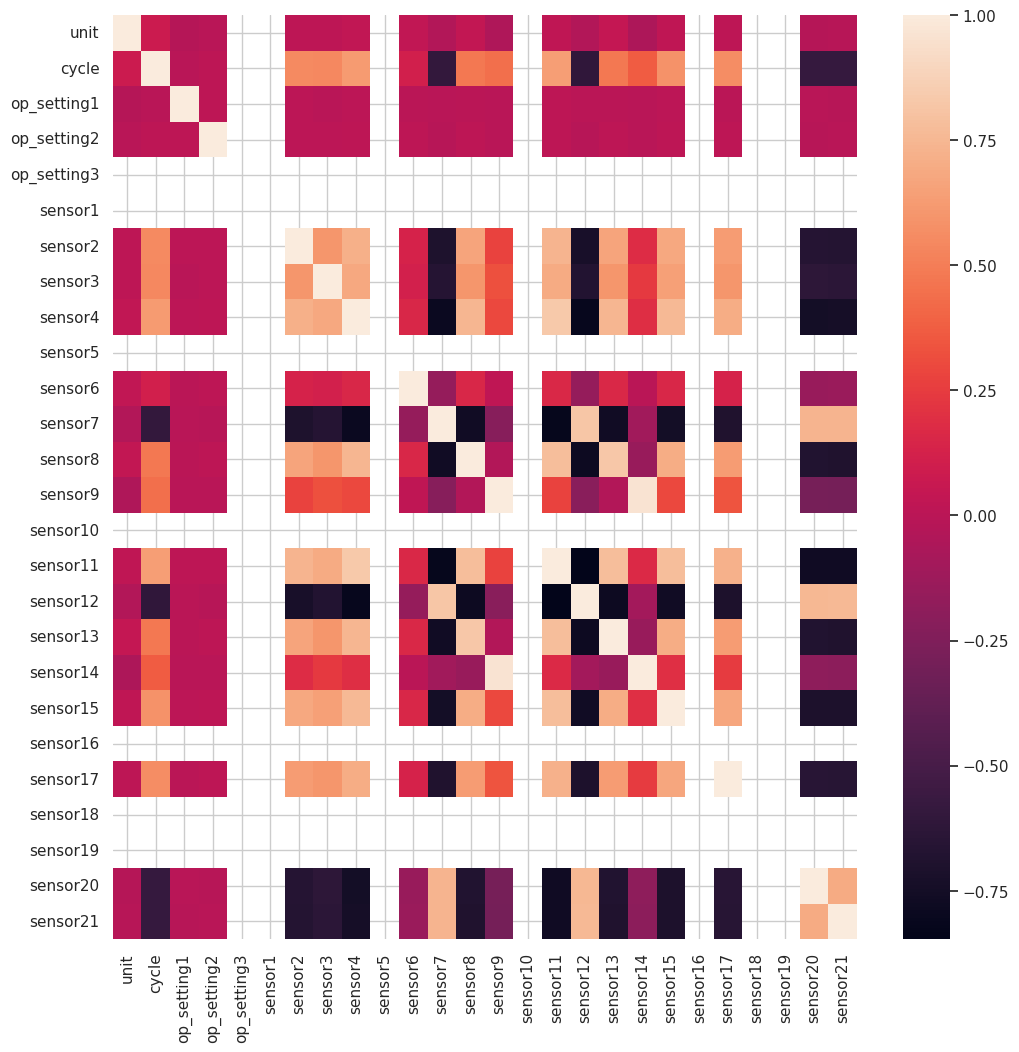

In [14]:
plt.figure(figsize=(12, 12))
sns.heatmap(X_train.corr())

In [ ]:
Many non-factor/constant fatures, let's remove them

In [15]:
constant_columns = (X_train.nunique()[X_train.nunique() == 1]).index
X_train.drop(constant_columns, axis=1, errors='ignore', inplace=True)
X_test.drop(constant_columns, axis=1, errors='ignore', inplace=True)

<Axes: >

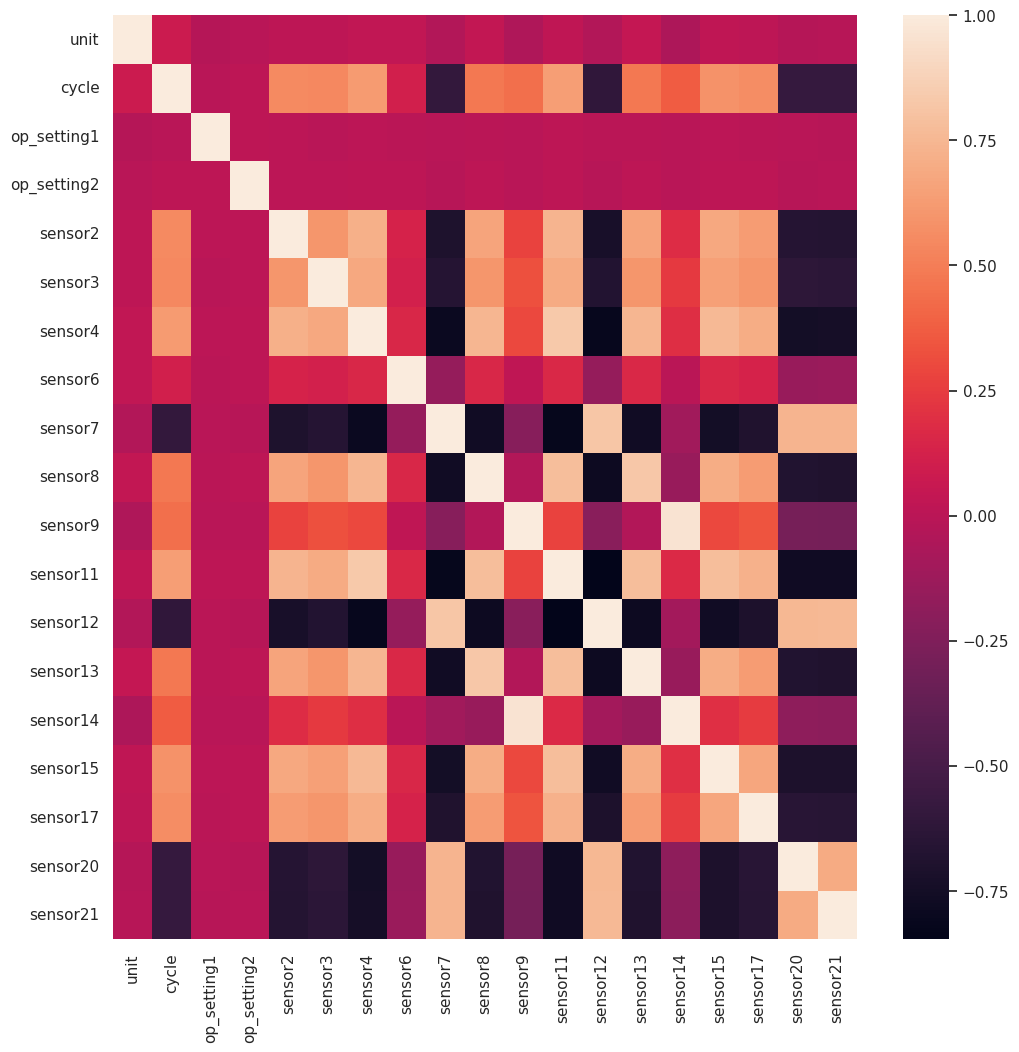

In [16]:
plt.figure(figsize=(12, 12))
sns.heatmap(X_train.corr())

Much better!

In [17]:
from sklearn import ensemble
rf = ensemble.RandomForestRegressor(n_estimators = 200, max_depth = 15)
rf.fit(X_train, y_train['remaining_cycles'])
y_pred = pd.DataFrame(rf.predict(X_test))
y_pred

,0
0,187.100470
1,194.147564
2,181.954348
3,182.919908
4,191.996375
...,...
13091,21.757339
13092,24.846250
13093,25.108333
13094,22.495000


<Axes: xlabel='importance', ylabel='feature'>

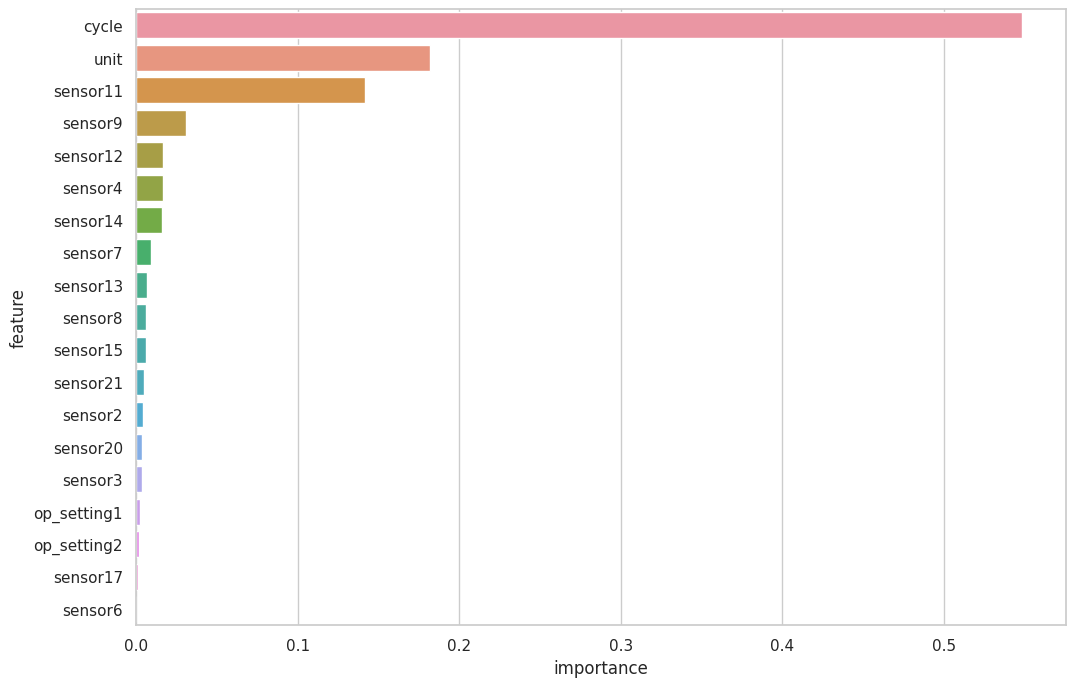

In [18]:
rf.feature_importances_
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=feature_importances)

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("r-squared: ", r2_score(y_test, y_pred))

r-squared:  0.22678717983832164


Text(0, 0.5, 'Predicted Remaining Life')

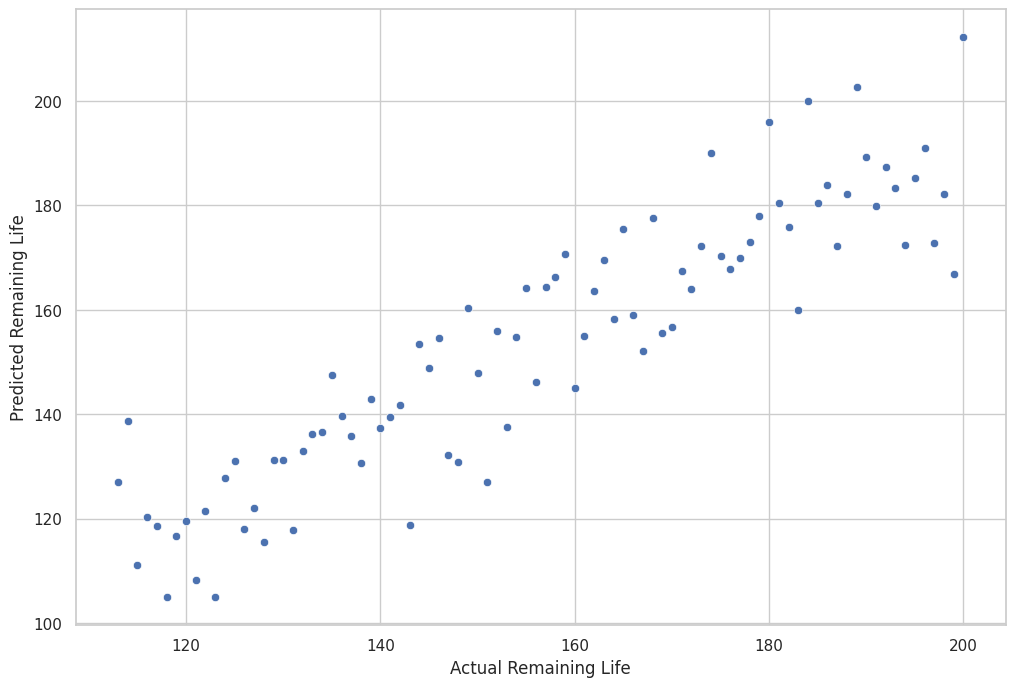

In [20]:
interested_unit = X_test.query('unit == 75').index
sns.scatterplot(x=y_test.loc[interested_unit].squeeze(), y=y_pred.loc[interested_unit].squeeze())
plt.xlabel('Actual Remaining Life')
plt.ylabel('Predicted Remaining Life')

In [21]:
"""
# Gradient Boosting
# create holdout
import numpy as np
from sklearn import preprocessing
# choose the model
from sklearn.ensemble import GradientBoostingRegressor
gb = ensemble.GradientBoostingRegressor()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', gb) ])
# tune the model
my_alpha = [.5, .75, .9]
my_n_estimators= [500]
my_learning_rate = [0.005, .01]
my_max_depth = [4, 5, 6]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_gb = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__max_depth = my_max_depth, model__n_estimators = my_n_estimators,
                                              model__learning_rate = my_learning_rate, model__alpha = my_alpha)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_gb.fit(X_train, y_train)
# show the best model estimators
print(optimized_gb.best_estimator_)
# evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = optimized_gb.predict(X_test)
print("Gradient Boosting Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Gradient Boosting Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("Gradient Boosting r-squared: ", r2_score(y_test, y_pred))
"""

'\n# Gradient Boosting\n# create holdout\nimport numpy as np\nfrom sklearn import preprocessing\n# choose the model\nfrom sklearn.ensemble import GradientBoostingRegressor\ngb = ensemble.GradientBoostingRegressor()\n# set up 5-fold cross-validation\nfrom sklearn import model_selection\ncv = model_selection.KFold(5)\n# pipeline standardization and model\nfrom sklearn.pipeline import Pipeline\npipeline = Pipeline(steps=[(\'standardize\', preprocessing.StandardScaler())\n                           , (\'model\', gb) ])\n# tune the model\nmy_alpha = [.5, .75, .9]\nmy_n_estimators= [500]\nmy_learning_rate = [0.005, .01]\nmy_max_depth = [4, 5, 6]\n# run the model using gridsearch, select the model with best search\nfrom sklearn.model_selection import GridSearchCV\noptimized_gb = GridSearchCV(estimator=pipeline\n                            , cv=cv\n                            , param_grid =dict(model__max_depth = my_max_depth, model__n_estimators = my_n_estimators,\n                           

Text(0, 0.5, 'Predicted Remaining Life')

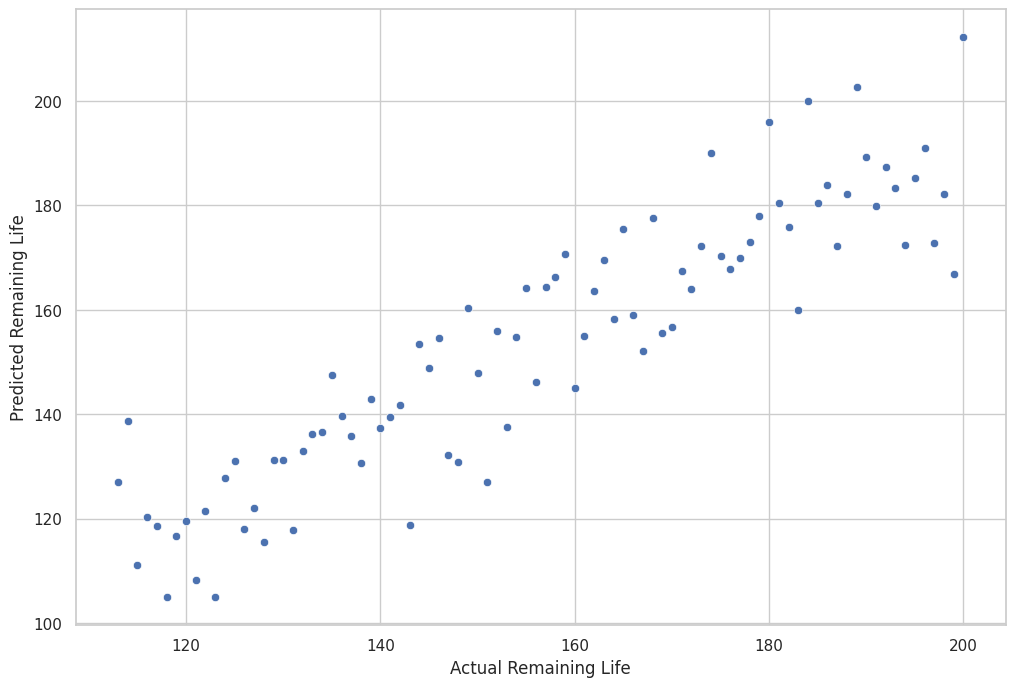

In [22]:
interested_unit = X_test.query('unit == 75').index
sns.scatterplot(x=y_test.loc[interested_unit].squeeze(), y=y_pred.loc[interested_unit].squeeze())
plt.xlabel('Actual Remaining Life')
plt.ylabel('Predicted Remaining Life')